<a href="https://colab.research.google.com/github/sirius70/NLP_HW4/blob/main/IE7275_Quiz4_Fall2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IE7275: Data Mining in Engineering
## Quiz 4 – Fall 2025

This quiz contains **20 questions**, covering advanced topics in data mining and preprocessing.  

Topics include:  
- Preprocessing pipelines and mixed-type data  
- Text and datetime feature extraction  
- Handling imbalanced and skewed datasets  
- Time series feature engineering and smoothing  
- Association rule mining with Apriori and FP-Growth  

---

**Instructions:**  
- Answer all questions in Python.  
- Show outputs clearly (tables/plots where requested).  
- Submit your completed notebook as a PDF on Canvas.   


### Dataset 1: Mixed Numerical and Categorical Data (for Q1–Q5)
Generate the dataset:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)
df1 = pd.DataFrame({
    'Age': np.random.randint(18,70,200),
    'Income': np.random.normal(50000,15000,200),
    'Gender': np.random.choice(['Male','Female','Other'],200),
    'City': np.random.choice(['Boston','NYC','SF','LA'],200),
    'Purchased': np.random.choice([0,1],200,p=[0.6,0.4])
})
train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
train1.head()


,Age,Income,Gender,City,Purchased
79,53,64376.207543,Male,SF,0
197,58,24253.633311,Male,Boston,0
38,61,43753.154547,Male,SF,0
24,38,82380.927850,Male,LA,1
122,24,26728.490839,Other,Boston,1


**Q1.**  
Build a preprocessing pipeline that imputes missing values, scales numeric features, one-hot encodes categorical features, and trains a logistic regression classifier. Evaluate on the test set.  

**Q2.**  
Compare performance of logistic regression and random forest classifiers using the same preprocessing pipeline. Report accuracy and F1-score.  

**Q3.**  
Add polynomial interaction terms for numerical features. Evaluate whether they improve model performance.  

**Q4.**  
Perform k-fold cross-validation on your pipeline with logistic regression. Report mean and standard deviation of accuracy.  

**Q5.**  
Interpret feature importance from the random forest model. Which features (including encoded ones) are most predictive of `Purchased`?  


In [2]:
# Q1

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split features and target
X_train = train1.drop('Purchased', axis=1)
y_train = train1['Purchased']

X_test = test1.drop('Purchased', axis=1)
y_test = test1['Purchased']

# Columns
num_cols = ['Age', 'Income']
cat_cols = ['Gender', 'City']

# Preprocessing
preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), num_cols),

    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# Model pipeline
model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
model.fit(X_train, y_train)

# Test
preds = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print("\nReport:\n", classification_report(y_test, preds))


Accuracy: 0.525

Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64        25
           1       0.33      0.27      0.30        15

    accuracy                           0.53        40
   macro avg       0.47      0.47      0.47        40
weighted avg       0.50      0.53      0.51        40



In [3]:
# Q2

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

for name, clf in models.items():
    pipe = Pipeline([
        ('prep', preprocess),
        ('clf', clf)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    print(name)
    print("Accuracy:", round(accuracy_score(y_test, preds), 3))
    print("F1-score:", round(f1_score(y_test, preds), 3))
    print()


Logistic Regression
Accuracy: 0.525
F1-score: 0.296

Random Forest
Accuracy: 0.6
F1-score: 0.467



In [4]:
# Q3
from sklearn.preprocessing import PolynomialFeatures

# New numeric pipeline with interaction terms
num_poly_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scale', StandardScaler())
])

# Updated preprocessing
preprocess_poly = ColumnTransformer([
    ('num', num_poly_pipeline, ['Age', 'Income']),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), ['Gender', 'City'])
])

# Model with polynomial features
poly_model = Pipeline([
    ('prep', preprocess_poly),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train & evaluate
poly_model.fit(X_train, y_train)
poly_preds = poly_model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, poly_preds), 3))
print("F1-score:", round(f1_score(y_test, poly_preds), 3))


Accuracy: 0.525
F1-score: 0.296


In [5]:
# Q4
from sklearn.model_selection import cross_val_score

# Logistic Regression pipeline (same preprocessing as Q1)
cv_model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

# 5-fold cross-validation on training data
cv_scores = cross_val_score(
    cv_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("Mean Accuracy:", round(cv_scores.mean(), 3))
print("Std Deviation:", round(cv_scores.std(), 3))


Mean Accuracy: 0.619
Std Deviation: 0.05


In [6]:
# Q5

# Train Random Forest on full training set (if not already)
rf_model = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(random_state=42))
])
rf_model.fit(X_train, y_train)

# Get feature names after preprocessing
num_features = ['Age', 'Income']
cat_features = rf_model.named_steps['prep'].named_transformers_['cat']\
               .named_steps['onehot'].get_feature_names_out(['Gender', 'City'])
all_features = np.concatenate([num_features, cat_features])

# Get feature importances from Random Forest
importances = rf_model.named_steps['clf'].feature_importances_

# Combine into a DataFrame for easy viewing
feat_imp = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feat_imp


,Feature,Importance
1,Income,0.415102
0,Age,0.379543
7,City_NYC,0.034792
4,Gender_Other,0.032498
5,City_Boston,0.030354
3,Gender_Male,0.029873
2,Gender_Female,0.028175
8,City_SF,0.024875
6,City_LA,0.024787


Interpretation:

In the Random Forest model, Income and Age are the most important features, while cities and gender contribute a little. This shows the model mainly relies on numeric factors to predict Purchased, with categorical features having minor influence.

### Dataset 2: Text and Datetime Data (for Q6–Q10)
Generate the dataset:

In [7]:
import datetime
from sklearn.datasets import fetch_20newsgroups

# Text sample from sklearn dataset
categories = ['sci.space','comp.graphics']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, remove=('headers','footers','quotes'))
texts = newsgroups.data[:200]

np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=200, freq="D")
df2 = pd.DataFrame({
    'Text': texts,
    'Date': dates,
    'Label': np.random.choice([0,1],200)
})
df2.head()


,Text,Date,Label
0,"\nI usually use ""Algorithms for graphics and i...",2020-01-01,0
1,"\n\n\n\n\n\nIt still applies, except the astro...",2020-01-02,1
2,I am currently using POVRay on Mac and was won...,2020-01-03,0
3,"I read it refered to as the ""parabolic cross-s...",2020-01-04,0
4,[Lots of stuff about how the commerical moonba...,2020-01-05,0


**Q6.**  
Vectorize the `Text` column using TF-IDF. Display the top 10 words with highest average TF-IDF scores.  

**Q7.**  
Compare TF-IDF with CountVectorizer on classification performance using logistic regression. Report accuracy.  

**Q8.**  
Extract year, month, day of week, and weekend flag from the `Date` column. Add them as new features. Show first 5 rows.  

**Q9.**  
Create lag features (`Label` shifted by 1 and 2 days). Train a logistic regression model with these lag features included. Report performance.  

**Q10.**  
Simulate rolling averages of the lagged features. Plot rolling mean and standard deviation. Interpret whether adding rolling statistics improves predictive power.  


In [8]:
# Q6

from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_tfidf = tfidf.fit_transform(df2['Text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Compute average TF-IDF per word
avg_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Top 10 words
top10_words = avg_tfidf.head(10)
print(top10_words)


space       0.038957
know        0.025315
thanks      0.024569
time        0.023334
don         0.023208
does        0.023190
like        0.021499
think       0.021486
just        0.021461
graphics    0.020098
dtype: float64


In [9]:
# Q7
from sklearn.feature_extraction.text import CountVectorizer


# Split dataset
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(
    df2['Text'], df2['Label'], test_size=0.2, random_state=42
)

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train_text)
pred_tfidf = lr_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test_text, pred_tfidf)

# CountVectorizer
count_vect = CountVectorizer(stop_words='english', max_features=1000)
X_train_count = count_vect.fit_transform(X_train_text)
X_test_count = count_vect.transform(X_test_text)

lr_count = LogisticRegression(max_iter=1000)
lr_count.fit(X_train_count, y_train_text)
pred_count = lr_count.predict(X_test_count)
acc_count = accuracy_score(y_test_text, pred_count)

# Display results
print("Accuracy with TF-IDF:", round(acc_tfidf, 3))
print("Accuracy with CountVectorizer:", round(acc_count, 3))


Accuracy with TF-IDF: 0.375
Accuracy with CountVectorizer: 0.4


In [10]:
# Q8

# Extract datetime features
df2['Year'] = df2['Date'].dt.year
df2['Month'] = df2['Date'].dt.month
df2['DayOfWeek'] = df2['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df2['IsWeekend'] = df2['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Show first 5 rows
df2.head()


,Text,Date,Label,Year,Month,DayOfWeek,IsWeekend
0,"\nI usually use ""Algorithms for graphics and i...",2020-01-01,0,2020,1,2,0
1,"\n\n\n\n\n\nIt still applies, except the astro...",2020-01-02,1,2020,1,3,0
2,I am currently using POVRay on Mac and was won...,2020-01-03,0,2020,1,4,0
3,"I read it refered to as the ""parabolic cross-s...",2020-01-04,0,2020,1,5,1
4,[Lots of stuff about how the commerical moonba...,2020-01-05,0,2020,1,6,1


In [11]:
# Q9

#from sklearn.metrics import accuracy_score, f1_score

# Create lag features
df2['Label_lag1'] = df2['Label'].shift(1).fillna(0)  # previous day
df2['Label_lag2'] = df2['Label'].shift(2).fillna(0)  # two days before

# Features: lag features only for this example
features = ['Label_lag1', 'Label_lag2']

X = df2[features]
y = df2['Label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", round(acc, 3))
print("F1-score:", round(f1, 3))


Accuracy: 0.55
F1-score: 0.571


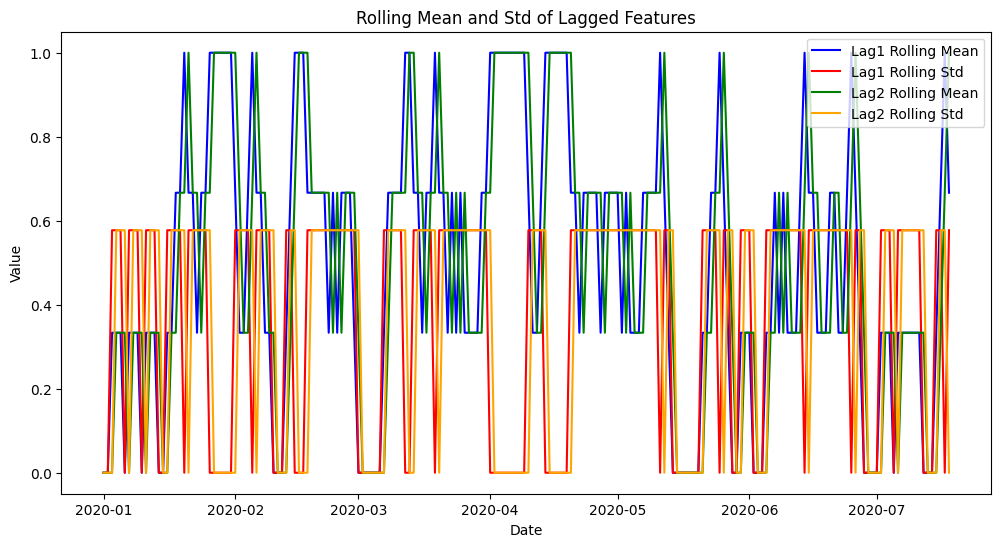

In [12]:
# Q10

import matplotlib.pyplot as plt

# Compute rolling mean and std (window=3 days) for lag features
df2['Lag1_roll_mean'] = df2['Label_lag1'].rolling(window=3, min_periods=1).mean()
df2['Lag1_roll_std'] = df2['Label_lag1'].rolling(window=3, min_periods=1).std().fillna(0)

df2['Lag2_roll_mean'] = df2['Label_lag2'].rolling(window=3, min_periods=1).mean()
df2['Lag2_roll_std'] = df2['Label_lag2'].rolling(window=3, min_periods=1).std().fillna(0)

# Plot rolling statistics
plt.figure(figsize=(12,6))
plt.plot(df2['Date'], df2['Lag1_roll_mean'], label='Lag1 Rolling Mean', color='blue')
plt.plot(df2['Date'], df2['Lag1_roll_std'], label='Lag1 Rolling Std', color='red')
plt.plot(df2['Date'], df2['Lag2_roll_mean'], label='Lag2 Rolling Mean', color='green')
plt.plot(df2['Date'], df2['Lag2_roll_std'], label='Lag2 Rolling Std', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling Mean and Std of Lagged Features')
plt.legend()
plt.show()


* The rolling mean and standard deviation smooth out short-term fluctuations in the lagged labels.

* These features capture recent trends and variability, which may help the model understand patterns over time.

* Including rolling statistics could improve predictive power if the label exhibits temporal correlation, but their benefit depends on how consistent the trend is.

### Dataset 3: Imbalanced and Skewed Data (for Q11–Q15)
Generate the dataset:

In [13]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_features=6, n_informative=3, n_redundant=1,
                           weights=[0.85,0.15], random_state=42)
df3 = pd.DataFrame(X, columns=[f'Feature{i}' for i in range(1,7)])
df3['Target'] = y

# Introduce skewed distribution
df3['Feature1'] = np.random.exponential(scale=2, size=500)
df3.head()


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Target
0,0.063867,-1.353743,2.206182,0.596442,0.220617,-0.805372,0
1,2.023459,0.476350,0.634273,0.743816,0.484331,-1.037018,1
2,0.754793,-0.928537,-0.543044,0.051626,-0.980763,0.537091,0
3,1.420874,-0.988350,1.118117,0.611144,-1.743860,1.479079,0
4,4.762531,-0.058551,0.573364,0.779567,-0.148604,1.585646,0


**Q11.**  
Check class imbalance in the `Target` column. Apply SMOTE to balance the dataset. Show new class distribution.  

**Q12.**  
Train logistic regression and random forest classifiers on the original imbalanced dataset. Compare precision, recall, and F1-score.  

**Q13.**  
Apply log transformation to `Feature1`. Compare skewness before and after transformation. Plot histograms.  

**Q14.**  
Apply Box-Cox transformation to `Feature1`. Compare with log transformation. Which works better?  

**Q15.**  
Apply Yeo-Johnson transformation to `Feature1`. Compare skewness reduction with Box-Cox and log. Which is most effective?  


In [14]:
# Q11

from collections import Counter
from imblearn.over_sampling import SMOTE

# Check class distribution
print("Original class distribution:", Counter(df3['Target']))

# Split features and target
X = df3.drop('Target', axis=1)
y = df3['Target']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# New class distribution
print("Resampled class distribution:", Counter(y_res))


Original class distribution: Counter({0: 424, 1: 76})
Resampled class distribution: Counter({0: 424, 1: 424})


In [15]:
# Q12

from sklearn.metrics import classification_report

# Split original imbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Compare performance
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92        81
           1       0.78      0.37      0.50        19

    accuracy                           0.86       100
   macro avg       0.82      0.67      0.71       100
weighted avg       0.85      0.86      0.84       100

Random Forest:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        81
           1       0.80      0.63      0.71        19

    accuracy                           0.90       100
   macro avg       0.86      0.80      0.82       100
weighted avg       0.90      0.90      0.90       100



Skewness before log transform: 1.885
Skewness after log transform: 0.361


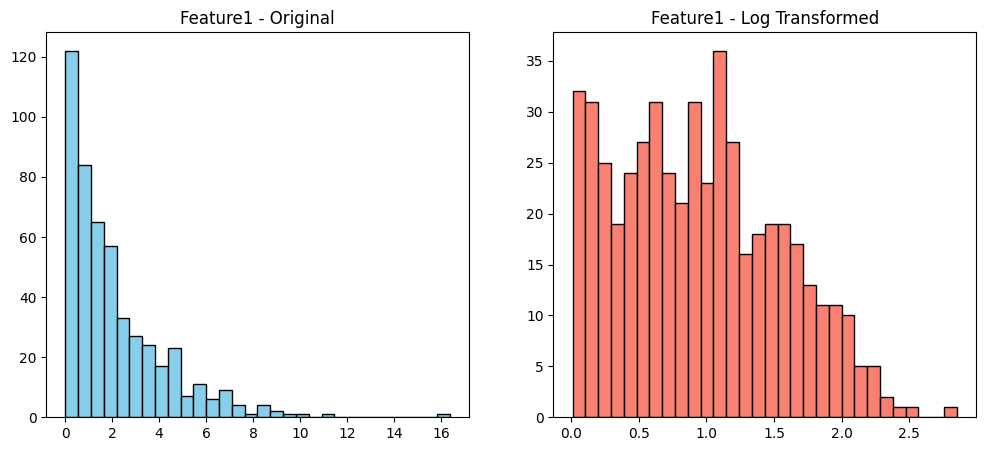

In [16]:
# Q13


# Skewness before transformation
skew_before = df3['Feature1'].skew()
print("Skewness before log transform:", round(skew_before, 3))

# Apply log transformation (add 1 to avoid log(0))
df3['Feature1_log'] = np.log1p(df3['Feature1'])

# Skewness after transformation
skew_after = df3['Feature1_log'].skew()
print("Skewness after log transform:", round(skew_after, 3))

# Plot histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df3['Feature1'], bins=30, color='skyblue', edgecolor='black')
plt.title('Feature1 - Original')

plt.subplot(1,2,2)
plt.hist(df3['Feature1_log'], bins=30, color='salmon', edgecolor='black')
plt.title('Feature1 - Log Transformed')

plt.show()


Skewness after log transform: 0.361
Skewness after Box-Cox transform: -0.068
Box-Cox lambda: 0.264


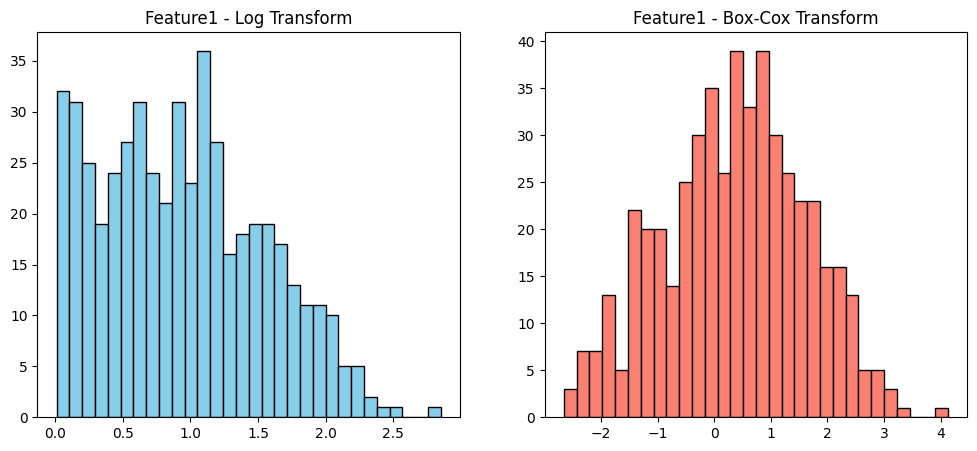

In [17]:
# Q14

from scipy.stats import boxcox

# Feature1 must be positive for Box-Cox
# Add a small constant to avoid zeros
feature1_positive = df3['Feature1'] + 1e-6

# Apply Box-Cox transformation
df3['Feature1_boxcox'], fitted_lambda = boxcox(feature1_positive)

# Compare skewness
skew_log = df3['Feature1_log'].skew()
skew_boxcox = df3['Feature1_boxcox'].skew()

print("Skewness after log transform:", round(skew_log, 3))
print("Skewness after Box-Cox transform:", round(skew_boxcox, 3))
print("Box-Cox lambda:", round(fitted_lambda, 3))

# Plot comparison
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df3['Feature1_log'], bins=30, color='skyblue', edgecolor='black')
plt.title('Feature1 - Log Transform')

plt.subplot(1,2,2)
plt.hist(df3['Feature1_boxcox'], bins=30, color='salmon', edgecolor='black')
plt.title('Feature1 - Box-Cox Transform')

plt.show()


Skewness after log transform: 0.361
Skewness after Box-Cox transform: -0.068
Skewness after Yeo-Johnson transform: 0.056


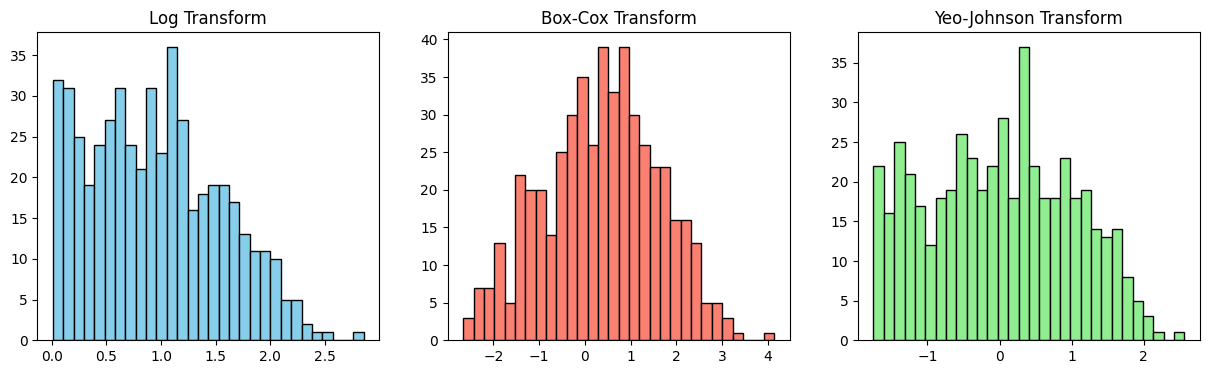

In [18]:
# Q15

from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation (works for positive & zero/negative values)
pt = PowerTransformer(method='yeo-johnson')
df3['Feature1_yeojohnson'] = pt.fit_transform(df3[['Feature1']])

# Compare skewness
skew_log = df3['Feature1_log'].skew()
skew_boxcox = df3['Feature1_boxcox'].skew()
skew_yeo = df3['Feature1_yeojohnson'].skew()

print("Skewness after log transform:", round(skew_log, 3))
print("Skewness after Box-Cox transform:", round(skew_boxcox, 3))
print("Skewness after Yeo-Johnson transform:", round(skew_yeo, 3))

# Plot comparison
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(df3['Feature1_log'], bins=30, color='skyblue', edgecolor='black')
plt.title('Log Transform')

plt.subplot(1,3,2)
plt.hist(df3['Feature1_boxcox'], bins=30, color='salmon', edgecolor='black')
plt.title('Box-Cox Transform')

plt.subplot(1,3,3)
plt.hist(df3['Feature1_yeojohnson'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Yeo-Johnson Transform')

plt.show()


Feature1 was highly skewed (1.885) originally. Applying a log transformation reduced skewness to 0.361, Box-Cox reduced it further to -0.068 (λ = 0.264), and Yeo-Johnson achieved the lowest skew at 0.056. This shows that while log helps moderately, Box-Cox and Yeo-Johnson are more effective, with Yeo-Johnson being the best overall for normalizing the feature.

### Dataset 4: Transactional Data (for Q16–Q20)
Generate the dataset:

In [19]:
from mlxtend.preprocessing import TransactionEncoder

transactions = [
    ['milk','bread','eggs'],
    ['milk','diapers','beer','bread'],
    ['bread','butter'],
    ['beer','diapers','chips'],
    ['milk','bread','butter','beer'],
    ['eggs','bread','milk'],
    ['bread','chips','diapers','milk'],
    ['beer','bread','milk']
]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df4 = pd.DataFrame(te_ary, columns=te.columns_)
df4.head()


,beer,bread,butter,chips,diapers,eggs,milk
0,False,True,False,False,False,True,True
1,True,True,False,False,True,False,True
2,False,True,True,False,False,False,False
3,True,False,False,True,True,False,False
4,True,True,True,False,False,False,True


**Q16.**  
Mine frequent itemsets using Apriori with minimum support 0.3. Display results.  

**Q17.**  
Generate association rules from these itemsets with minimum confidence 0.7. Show support, confidence, and lift.  

**Q18.**  
Apply FP-Growth with the same support threshold. Compare runtime and output with Apriori.  

**Q19.**  
Filter rules where the antecedent contains `milk`. Display top rules by lift.  

**Q20.**  
Rank rules by support, confidence, and lift. Select top 5 by each metric. Discuss differences in selected rules.  


In [20]:
# Q16

from mlxtend.frequent_patterns import apriori

# Mine frequent itemsets with min support 0.3
frequent_itemsets = apriori(df4, min_support=0.3, use_colnames=True)

# Sort by support descending
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

frequent_itemsets


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,support,itemsets
1,0.875,(bread)
3,0.750,(milk)
6,0.750,"(bread, milk)"
0,0.500,(beer)
2,0.375,(diapers)
4,0.375,"(bread, beer)"
5,0.375,"(milk, beer)"
7,0.375,"(bread, milk, beer)"


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [21]:
# Q17

from mlxtend.frequent_patterns import association_rules

# Generate association rules with min confidence 0.7
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Select relevant columns and sort by confidence
rules = rules[['antecedents','consequents','support','confidence','lift']].sort_values(by='confidence', ascending=False)

rules


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
1,(milk),(bread),0.750,1.000000,1.142857
5,"(milk, beer)",(bread),0.375,1.000000,1.142857
4,"(bread, beer)",(milk),0.375,1.000000,1.333333
0,(bread),(milk),0.750,0.857143,1.142857
2,(beer),(bread),0.375,0.750000,0.857143
3,(beer),(milk),0.375,0.750000,1.000000
6,(beer),"(bread, milk)",0.375,0.750000,1.000000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [22]:
# Q18

from mlxtend.frequent_patterns import fpgrowth
import time

# Measure runtime for FP-Growth
start_time = time.time()
fp_itemsets = fpgrowth(df4, min_support=0.3, use_colnames=True)
fp_time = time.time() - start_time

# Measure runtime for Apriori for comparison
start_time_ap = time.time()
apriori_itemsets = apriori(df4, min_support=0.3, use_colnames=True)
ap_time = time.time() - start_time_ap

# Show results
print("FP-Growth frequent itemsets:")
print(fp_itemsets.sort_values(by='support', ascending=False))

print("\nApriori frequent itemsets:")
print(apriori_itemsets.sort_values(by='support', ascending=False))

print(f"\nFP-Growth runtime: {fp_time:.4f} seconds")
print(f"Apriori runtime: {ap_time:.4f} seconds")


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

FP-Growth frequent itemsets:
   support             itemsets
0    0.875              (bread)
1    0.750               (milk)
4    0.750        (bread, milk)
2    0.500               (beer)
3    0.375            (diapers)
5    0.375         (milk, beer)
6    0.375        (bread, beer)
7    0.375  (bread, milk, beer)

Apriori frequent itemsets:
   support             itemsets
1    0.875              (bread)
3    0.750               (milk)
6    0.750        (bread, milk)
0    0.500               (beer)
2    0.375            (diapers)
4    0.375        (bread, beer)
5    0.375         (milk, beer)
7    0.375  (bread, milk, beer)

FP-Growth runtime: 0.0201 seconds
Apriori runtime: 0.0180 seconds


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Conclusion: FP-Growth is slightly faster than Apriori while producing identical frequent itemsets.

In [23]:
# Q19

# Filter rules where antecedent contains 'milk'
milk_rules = rules[rules['antecedents'].apply(lambda x: 'milk' in x)]

# Sort by lift descending
milk_rules = milk_rules.sort_values(by='lift', ascending=False)

milk_rules


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,antecedents,consequents,support,confidence,lift
1,(milk),(bread),0.750,1.0,1.142857
5,"(milk, beer)",(bread),0.375,1.0,1.142857


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [24]:
# Q20

# Top 5 rules by support
top_support = rules.sort_values(by='support', ascending=False).head(5)

# Top 5 rules by confidence
top_confidence = rules.sort_values(by='confidence', ascending=False).head(5)

# Top 5 rules by lift
top_lift = rules.sort_values(by='lift', ascending=False).head(5)

print("Top 5 rules by support:")
print(top_support)

print("\nTop 5 rules by confidence:")
print(top_confidence)

print("\nTop 5 rules by lift:")
print(top_lift)


Top 5 rules by support:
     antecedents consequents  support  confidence      lift
1         (milk)     (bread)    0.750    1.000000  1.142857
0        (bread)      (milk)    0.750    0.857143  1.142857
5   (milk, beer)     (bread)    0.375    1.000000  1.142857
4  (bread, beer)      (milk)    0.375    1.000000  1.333333
2         (beer)     (bread)    0.375    0.750000  0.857143

Top 5 rules by confidence:
     antecedents consequents  support  confidence      lift
1         (milk)     (bread)    0.750    1.000000  1.142857
5   (milk, beer)     (bread)    0.375    1.000000  1.142857
4  (bread, beer)      (milk)    0.375    1.000000  1.333333
0        (bread)      (milk)    0.750    0.857143  1.142857
2         (beer)     (bread)    0.375    0.750000  0.857143

Top 5 rules by lift:
     antecedents consequents  support  confidence      lift
4  (bread, beer)      (milk)    0.375    1.000000  1.333333
1         (milk)     (bread)    0.750    1.000000  1.142857
5   (milk, beer)     (brea

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

The rules selected by support, confidence, and lift highlight different aspects of the data. Support favors rules that occur most frequently in transactions, so common items like (milk) → (bread) appear at the top. Confidence favors rules that are most reliable or predictive when the antecedent occurs, which includes both common rules and combinations like (beer, bread) → (milk) that perfectly predict the consequent. Lift emphasizes rules that show the strongest association relative to chance, even if they are less frequent, highlighting interesting but less obvious patterns like (beer, bread) → (milk). In short, support focuses on frequency, confidence on predictive reliability, and lift on the strength of association, which is why the top rules differ across metrics.